In [1]:
import numpy as np
import scipy.stats as ss
import numpy.random as npr
import pandas as pd

import seaborn as sns
import pylab as pl
import collections

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def generate_user(n_classes=2, n_components=2, n_interests=2, p_c=[0.3, 0.7], p_m=[[0.99, 0.01], [0.5, 0.5]], mu=[35.0, 20.0], std=10.0, lbd=[2.0, 3.0], p_i=[[0.2, 0.3], [0.6, 0.9]]):
    assert len(p_c) == n_classes
    assert np.array(p_m).shape == (n_classes, n_components)
    assert np.array(p_i).shape == (n_classes, n_interests)
    
    result = {}
    
    klass = np.arange(n_classes)[npr.multinomial(1, p_c).astype(bool)][0]
    # print "Sampled class: %s" % klass
    result["klass"] = klass    
    
    for j in xrange(n_interests):
        result["int_%d" % j] = int(npr.random() < p_i[klass][j])
    
    p_mix = p_m[klass]
    # print "P_mixture: %s" % p_mix    
    
    n_presents = npr.zipf(2.4, 1)
    for j in xrange(n_presents):   
        component = np.arange(n_components)[npr.multinomial(1, p_mix).astype(bool)][0]
        # print "Sampled_component: %s" % component    

        if component == 0:
            # Exponential
            p = np.ceil(npr.exponential(1.0/lbd[klass]))
        elif component == 1:
            # Normal
            p = int(npr.normal(mu[klass], std, 1)[0] + 1)
        # print "Sampled price %s" % p        
        
        if p > 0 and p <= 100:
            result[p] = result.get(p, 0) + 1
    
    if sum([result.get(n, 0) for n in xrange(1, 101)]) > 0:
        return result
    else:
        return generate_user(n_classes, n_components, n_interests, p_c, p_m, mu, std, lbd, p_i)    

In [52]:
df = pd.DataFrame([generate_user() for i in xrange(10000)], columns=["klass", "int_0", "int_1"] + range(1, 101))
df.fillna(0, inplace=True)

df.head()

klass  int_0  int_1  1  2  3  4  5  6  7 ...   91  92  93  94  95  96  97  \
0      0      0      0  2  0  0  0  0  0  0 ...    0   0   0   0   0   0   0   
1      1      1      1  1  0  0  0  0  0  0 ...    0   0   0   0   0   0   0   
2      1      0      1  0  0  0  0  0  0  0 ...    0   0   0   0   0   0   0   
3      1      0      1  6  0  0  0  0  0  0 ...    0   0   0   0   0   0   0   
4      1      0      1  0  0  0  0  0  0  0 ...    0   0   0   0   0   0   0   

   98  99  100  
0   0   0    0  
1   0   0    0  
2   0   0    0  
3   0   0    0  
4   0   0    0  

[5 rows x 103 columns]

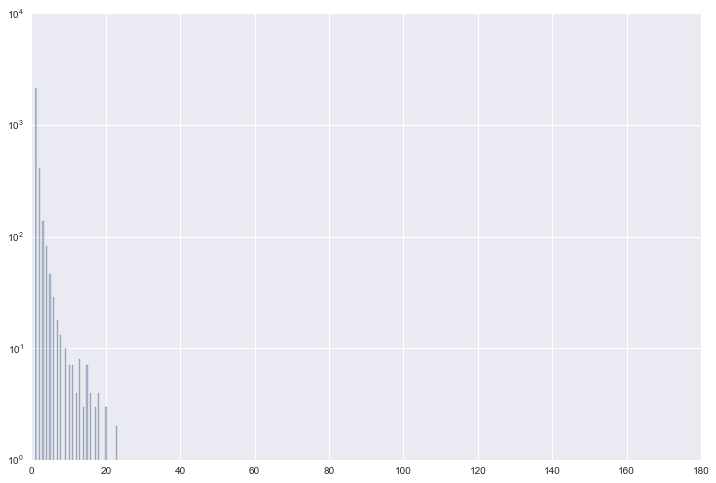

In [53]:
pl.figure(figsize=(12, 8))
sns.distplot(df[df["klass"] == 0][range(1, 101)].sum(axis=1), bins=500, rug=False, kde=False)
pl.gca().set_yscale('log')
pl.show()

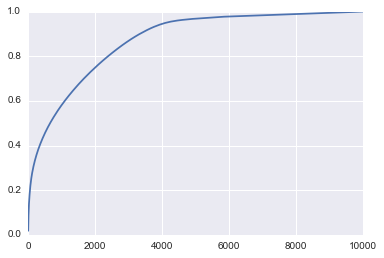

klass  int_0  int_1  1  2  3  4  5  6  7 ...   91  92  93  94  95  96  \
4855      1      0      1  1  0  0  0  0  0  0 ...    0   0   0   0   0   0   
9269      1      0      1  0  0  0  0  0  0  0 ...    0   0   0   0   0   0   
3939      1      1      1  0  0  0  0  0  0  0 ...    0   0   0   0   0   0   
3597      1      1      1  2  0  0  0  0  0  0 ...    0   0   0   0   0   0   
26        1      1      1  0  0  0  0  0  0  0 ...    0   0   0   0   0   0   

      97  98  99  100  
4855   0   0   0    0  
9269   0   0   0    0  
3939   0   0   0    0  
3597   0   0   0    0  
26     0   0   0    0  

[5 rows x 103 columns]

In [54]:
spent = pd.Series(df[range(1, 101)].values.dot(range(1, 101)), index=df.index)

pl.plot(arange(df.shape[0]), np.cumsum(spent.sort_values(ascending=False)) / spent.sum())
pl.show()

# Take users that generate 80% of income and then sample from them
dfs = df.ix[spent.sort_values(ascending=False).index[:df.shape[0]/3]].sample(1000)

dfs.head()

In [55]:
dfs.head().sum(axis=1)

4855    5
9269    3
3939    4
3597    9
26      4
dtype: float64

In [56]:
def visualize_dist(dfx, N=None, M=None, color='r'):
    if N is None:
        N = np.ceil(np.sqrt(dfx.shape))
        M = np.ceil(np.sqrt(dfx.shape))

    fig = pl.figure(figsize=(M*3, N*3))

    for i, (uid, row) in enumerate(dfx.sample(N*M).iterrows()):
        ax = pl.subplot(N, M, i + 1)
#         print row.index, row.values
        ax.bar(row.index + 0.5, row.values, color=color, alpha=0.7)
        pl.title(uid)
        pl.xticks(range(0, 101, 20))
        pl.xlim(0, 101)
        pl.ylim(0, 100)
    
    fig.tight_layout()
    pl.show()

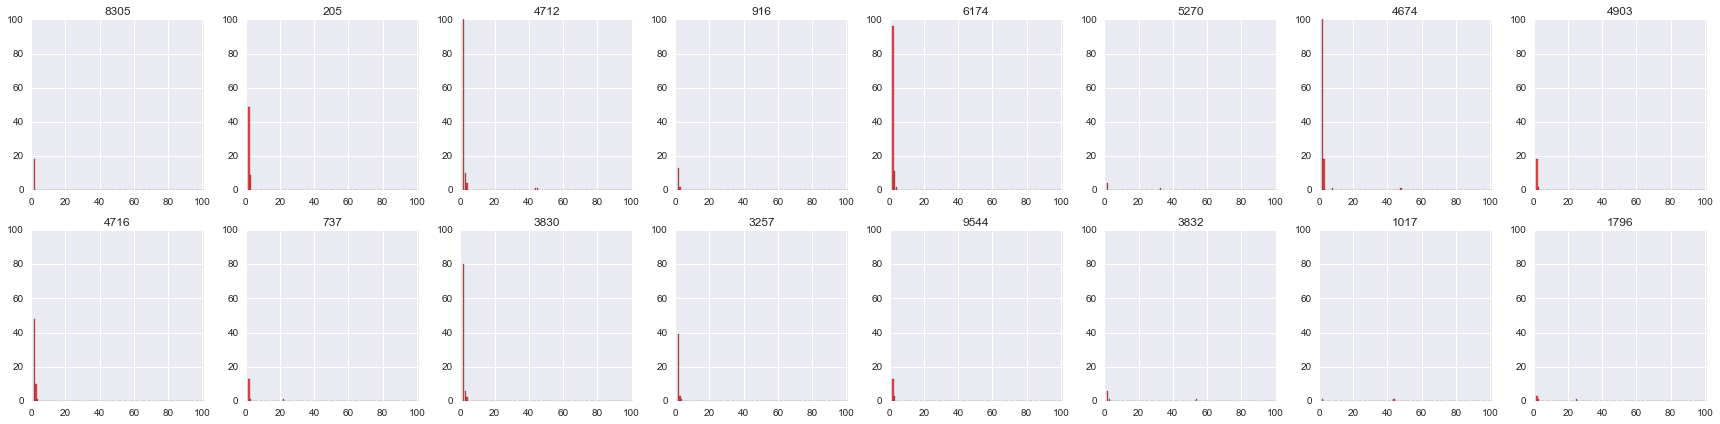

In [57]:
visualize_dist(dfs[dfs["klass"] == 0][range(1, 101)], 2, 8)

## Bayesian

### PyMC

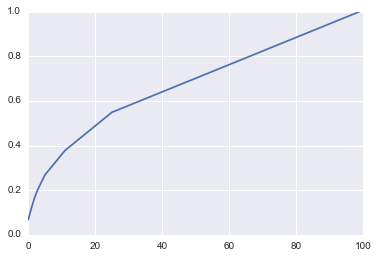

klass  int_0  int_1  int_2  int_3  int_4  int_5  int_6  1  2 ...   91  92  \
2       0      0      0      1      1      0      0      0  7  2 ...    0   0   
94      2      1      1      1      0      1      1      0  0  0 ...    0   0   
85      0      0      0      1      1      0      1      0  7  0 ...    0   0   
71      2      1      1      1      0      1      1      1  0  1 ...    0   0   
61      0      0      0      0      0      0      1      0  3  1 ...    0   0   

    93  94  95  96  97  98  99  100  
2    0   0   0   0   0   0   0    0  
94   0   0   0   0   0   0   0    0  
85   0   0   0   0   0   0   0    0  
71   0   0   0   0   0   0   0    0  
61   0   0   0   0   0   0   0    0  

[5 rows x 108 columns]

In [3]:
import pymc as pm

n_users = 10

n_classes = 3
n_interests = 7

p_c=[0.3, 0.2, 0.5]

p_m=[[0.8, 0.2], [0.5, 0.5], [0.1, 0.9]]
mu=[35.0, 20.0, 50.0]
std=10.0
lbd=[2.0, 3.0, 1.0]

p_i=[[0.2, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5], [0.6, 0.1, 0.3, 0.9, 0.1, 0.3, 0.9], [0.9, 0.8, 0.5, 0.1, 0.8, 0.5, 0.1]]

df = pd.DataFrame([generate_user(n_classes, 2, n_interests, p_c, p_m, mu, std, lbd, p_i) for i in xrange(n_users * 10)], columns=["klass"] + ["int_%d" % i for i in xrange(n_interests)] + range(1, 101))
df.fillna(0, inplace=True)

spent = pd.Series(df[range(1, 101)].sum(axis=1), index=df.index)

pl.plot(arange(df.shape[0]), np.cumsum(spent.sort_values(ascending=False)) / spent.sum())
pl.show()

# Take users that generate 80% of income and then sample from them
df = df.ix[spent.sort_values(ascending=False).index[:n_users]]

df.head()

In [4]:
df = pd.read_csv('/Users/anokhin/Desktop/train_set.csv').set_index('uid').sample(n_users)
df["klass"] = 0
df.head()

int_0  int_1  int_2  int_3  int_4  int_5  int_6   1  2  3  \
uid                                                                         
N:557360950981      0      0      0      0      1      1      0  61  4  0   
N:342768086326      1      0      0      1      0      0      0  17  9  1   
N:481104390818      0      0      0      0      0      0      0  18  0  0   
N:574254196533      1      0      1      0      1      0      0   9  4  0   
N:444903338346      0      0      0      0      0      0      1  23  0  0   

                ...    92  93  94  95  96  97  98  99  100  klass  
uid             ...                                                
N:557360950981  ...     0   0   0   0   0   0   0   0    0      0  
N:342768086326  ...     0   0   0   0   0   0   0   0    0      0  
N:481104390818  ...     0   0   0   0   0   0   0   0    0      0  
N:574254196533  ...     0   0   0   0   0   0   0   0    0      0  
N:444903338346  ...     0   0   0   0   0   0   0   0    0      0  

[5 rows x 108 columns]

In [5]:
print df.groupby(["klass"]).size()
n_classes = 4
# x = np.linspace(-10, 10, 1000)
# y = ss.expon.pdf(x, 0, 2./3)
# plot(x, y)

klass
0    10
dtype: int64


In [6]:
def interest_selector(klass, interest_priors):
    return interest_priors[klass]

def mixture_selector(klass, mixture_priors):
    return mixture_priors[klass]

def mu_selector(klass, mu_priors):
    return mu_priors[klass]

def tau(sigma):
    return 1 / sigma ** 2

def sigma_selector(klass, sigma_priors):
    return sigma_priors[klass]

def beta_selector(klass, beta_priors):
    return beta_priors[klass]

def price_rand(mixture_prior, mu_prior, sigma_prior, beta_prior):
    if npr.random() < mixture_prior:
        return npr.exponential(1.0 / beta_prior)
    else:
        return npr.normal(mu_prior, sigma_prior)       

def price_logp(value, mixture_prior, mu_prior, sigma_prior, beta_prior):    
    if isinstance(value, np.ndarray) and value.shape == ():        
        values = [value.tolist()]
    elif isinstance(value, collections.Iterable):
        values = value
    else:
        values = [value]      
        
    ll = 0
    for v in values:        
        ll += np.log(mixture_prior * ss.expon.pdf(v, 0, 1.0 / beta_prior) + (1 - mixture_prior) * ss.norm.pdf(v, mu_prior, sigma_prior))        
    return ll                                

def model_definition(n_classes, n_interests, n_users):
    # Class prior
    inc_klass_prior = pm.Dirichlet("inc_klass_prior", theta=np.ones(n_classes, dtype=float))
    klass_prior = pm.CompletedDirichlet("klass_prior", inc_klass_prior)
    
    # Priors for interests
    interests_priors = np.empty((n_interests, n_classes), dtype=object)
    for j in xrange(n_interests):
        for k in xrange(n_classes):        
            interests_priors[j, k] = pm.Uniform("interest_prior_%d_%d" % (j, k), 0, 1)
            
    # Priors for mixture probs
    mixture_priors = np.empty(n_classes, dtype=object)
    mu_priors = np.empty(n_classes, dtype=object)
    sigma_priors = np.empty(n_classes, dtype=object)
    beta_priors = np.empty(n_classes, dtype=object)
    for k in xrange(n_classes):
        mixture_priors[k] = pm.Uniform("mixture_prior_%d" % k, 0, 1)
        mu_priors[k] = pm.Normal("mu_prior_%d" % k, 10 * (k + 1), 0.01)
        sigma_priors[k] = pm.Uniform("sigma_prior_%d" % k, 0.01, 100)
        beta_priors[k] = pm.Uniform("beta_prior_%d" % k, 0.01, 5)

    # For each user generate class
    klasses = np.empty(n_users, dtype=object)
    # For each user generate 0-1 interests
    interests = np.empty((n_users, n_interests), dtype=object)
    interest_selectors = np.empty((n_users, n_interests), dtype=object)
    # For each user generate price
    mixtures = np.empty(n_users, dtype=object)
    mus = np.empty(n_users, dtype=object)    
    sigmas = np.empty(n_users, dtype=object)
    betas = np.empty(n_users, dtype=object)
    prices = np.empty(n_users, dtype=object)
    
    for i in xrange(n_users):        
        klass_value = int(df.iloc[i]["klass"])
        klasses[i] = pm.Categorical("klass_%d" % i, klass_prior) # , value=klass_value, observed=True)
        
        # Generate interests
        for j in xrange(n_interests):            
            interest_selectors[i, j] = pm.Deterministic(
                eval=interest_selector, 
                name='is_%d_%d' % (i, j), 
                doc="Assigns interest probability using current user's class", 
                parents={'klass': klasses[i], 'interest_priors': interests_priors[j, :]},
                verbose=0, dtype=float, plot=True
            )
            interests[i, j] = pm.Bernoulli("interest_%d_%d" % (i, j), interest_selectors[i, j], value=df.iloc[i]["int_%d" % j] > 0, observed=True)
            
        # Generate presents
        mixtures[i] = pm.Deterministic(
            eval=mixture_selector, 
            name='mix_s_%d' % i, 
            doc="Assigns mixture probability using current user's class", 
            parents={'klass': klasses[i], 'mixture_priors': mixture_priors},
            verbose=0, dtype=float, plot=True
        )
        
        mus[i] = pm.Deterministic(
            eval=mu_selector, 
            name='mu_s_%d' % i, 
            doc="Assigns normal center probability using current user's class", 
            parents={'klass': klasses[i], 'mu_priors': mu_priors},
            verbose=0, dtype=float, plot=True
        )
        
        sigmas[i] = pm.Deterministic(
            eval=sigma_selector, 
            name='sigma_s_%d' % i,
            doc="Assigns normal precision probability using current user's class", 
            parents={'klass': klasses[i], 'sigma_priors': sigma_priors},
            verbose=0, dtype=float, plot=True
        )
        
        betas[i] = pm.Deterministic(
            eval=beta_selector, 
            name='b_s_%d' % i, 
            doc="Assigns exponential precision probability using current user's class", 
            parents={'klass': klasses[i], 'beta_priors': beta_priors},
            verbose=0, dtype=float, plot=True
        )
        
        price_values = []
        for p in xrange(1, 101):
            price_values.extend([p] * df.iloc[i][p])
        
        prices[i] = pm.Stochastic(
            logp=price_logp,
            doc='The price of a gift for the user',
            name='price_%d' % i,
            parents = {'mixture_prior': mixtures[i], 'mu_prior': mus[i], 'sigma_prior': sigmas[i], 'beta_prior': betas[i]},
            random = price_rand,               
            dtype=float,
            plot=True,
            value=price_values,
            observed=True
        )
        
    return locals()

mcmc = pm.MCMC(model_definition(n_classes, n_interests, n_users), db='pickle', dbname='ok.pickle')

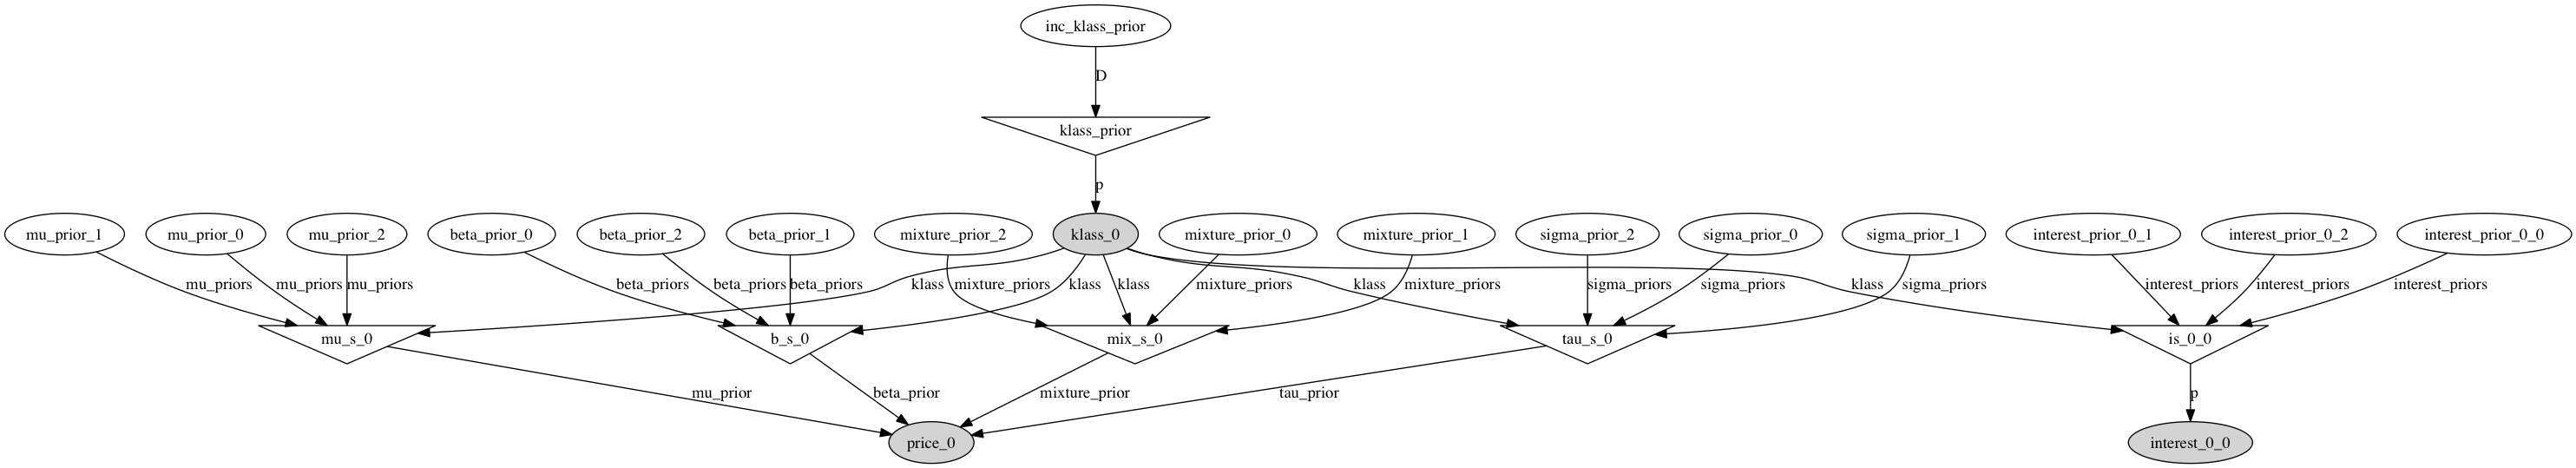

In [63]:
from IPython.display import Image
# gr = pm.graph.graph(mcmc)
# gr.write_png('/Users/anokhin/Desktop/model.png')
Image(filename='/Users/anokhin/Desktop/model.png')

In [16]:
mcmc.sample(3000, burn=0)
mcmc.db.close()

 [----             11%                  ] 342 of 3000 complete in 538.4 secHalting at iteration  341  of  3000


In [64]:
mcmc = pm.database.pickle.load('ok.pickle')

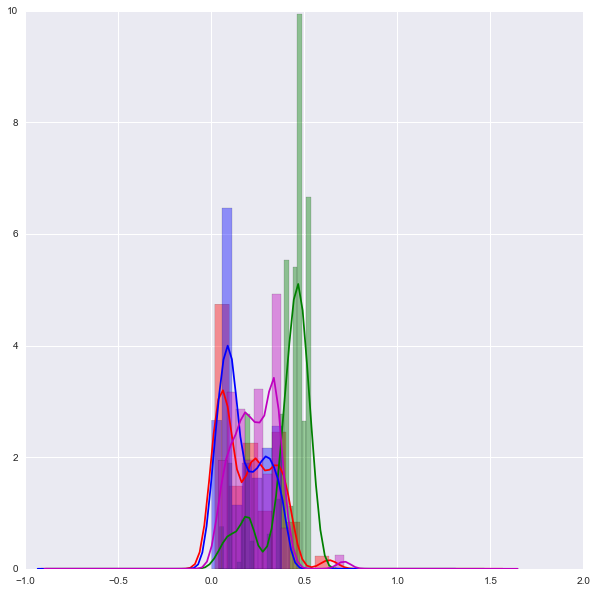

array([ 0.19172172,  0.4065593 ,  0.16637078,  0.2353482 ])

In [65]:
klass_prior_trace = mcmc.trace("klass_prior")[:].reshape(-1, n_classes)

# for pretty colors later in the book.
colors = ['r', 'g', 'b', 'm', 'y', 'c', 'k']

pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    sns.distplot(klass_prior_trace[:, k], label="class %d" % k, color=colors[k])

# pl.ylim(0, 50)
pl.show()

klass_prior_trace.mean(axis=0)

c=0, i=0 0.501015355331
c=1, i=0 0.177077860136
c=2, i=0 0.494556278072
c=3, i=0 0.54114192627
c=0, i=1 0.465765891793
c=1, i=1 0.266213491778
c=2, i=1 0.520052051322
c=3, i=1 0.532315803241
c=0, i=2 0.467264110491
c=1, i=2 0.408916864232
c=2, i=2 0.505103763141
c=3, i=2 0.502881267107
c=0, i=3 0.501475666953
c=1, i=3 0.0792716050881
c=2, i=3 0.458195796618
c=3, i=3 0.371076459515
c=0, i=4 0.402507193067
c=1, i=4 0.153198139698
c=2, i=4 0.509359762452
c=3, i=4 0.465943188883
c=0, i=5 0.525502913458
c=1, i=5 0.254274829192
c=2, i=5 0.450691456158
c=3, i=5 0.493860642433
c=0, i=6 0.490882334484
c=1, i=6 0.0722997579914
c=2, i=6 0.451074877262
c=3, i=6 0.454627204906


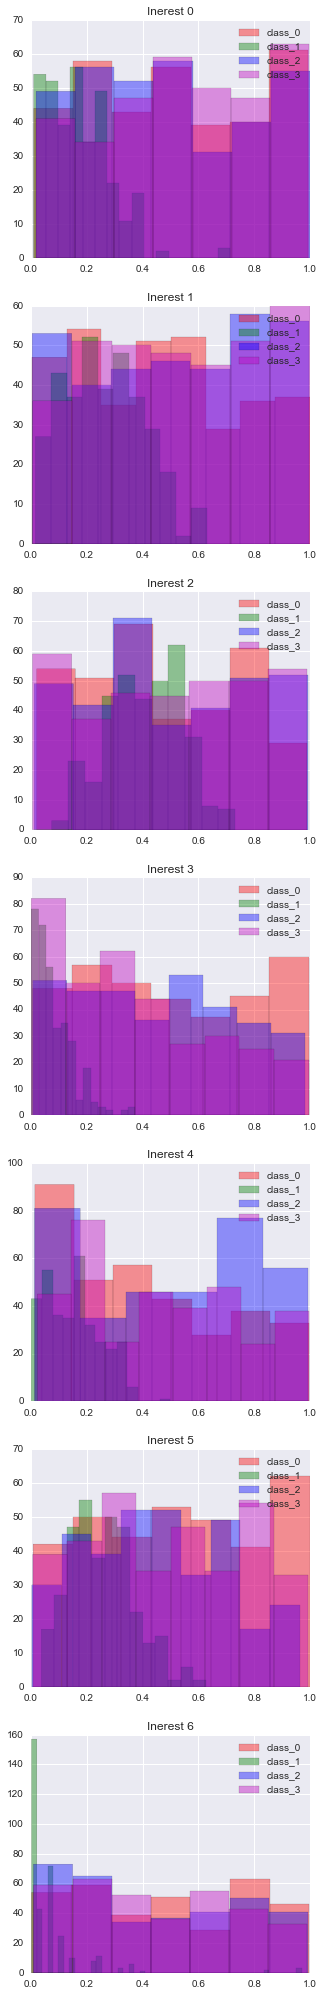

In [66]:
colors = ['r', 'g', 'b', 'm', 'y', 'c', 'k']

pl.figure(figsize=(5, n_interests * 5))
for i in xrange(n_interests):
    pl.subplot(n_interests, 1, i + 1)
    for k in xrange(n_classes):
        trace = mcmc.trace("interest_prior_%d_%d" % (i, k))[:]        
        sns.distplot(trace, label="class_%d" % k, color=colors[k], kde=False)
        print "c=%d, i=%d" % (k, i), trace.mean()
        pl.legend()
        pl.title("Inerest %d" % i)
pl.show()

0.477559271636
0.138584834283
0.547508597235
0.50956556709


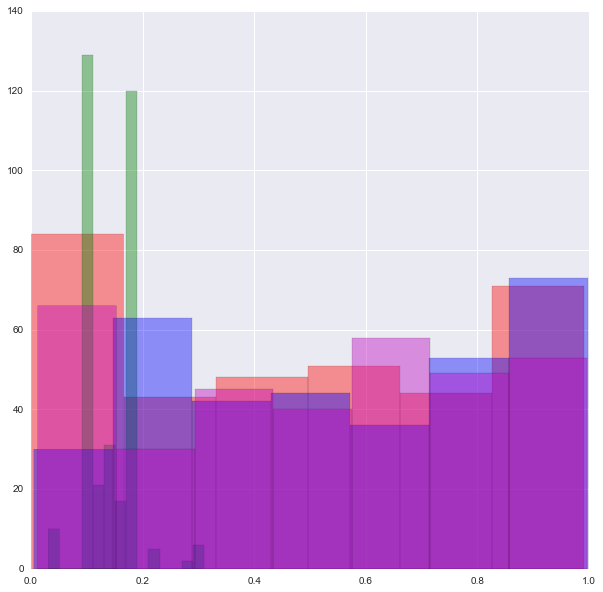

In [67]:
pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    mixture_prior_trace = mcmc.trace("mixture_prior_%d" % k)[:]
    sns.distplot(mixture_prior_trace, label="class %d" % k, color=colors[k], kde=False)
    print mixture_prior_trace.mean()

# pl.ylim(0, 50)
pl.show()

14.4896737383
7.0541031417
29.5033350249
39.68508224


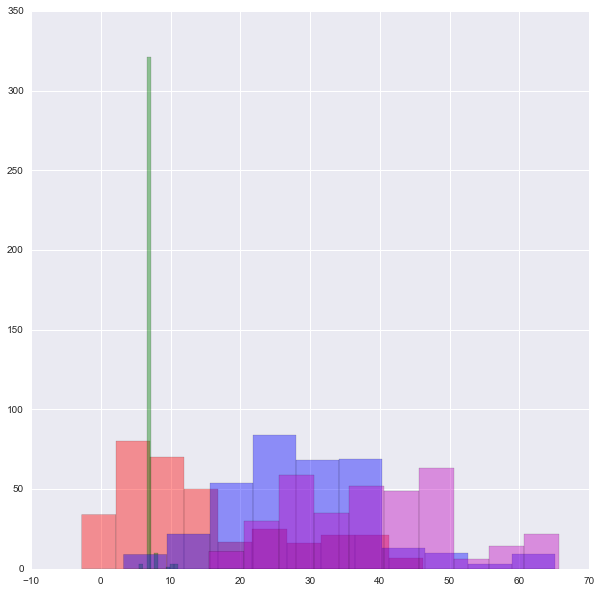

In [68]:
pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    mu_prior_trace = mcmc.trace("mu_prior_%d" % k)[:]
    sns.distplot(mu_prior_trace, label="class %d" % k, color=colors[k], kde=False, bins=10)
    print mu_prior_trace.mean()

# pl.ylim(0, 50)
pl.show()

2.3156707324
0.126568765473
2.89862711581
2.44166231945


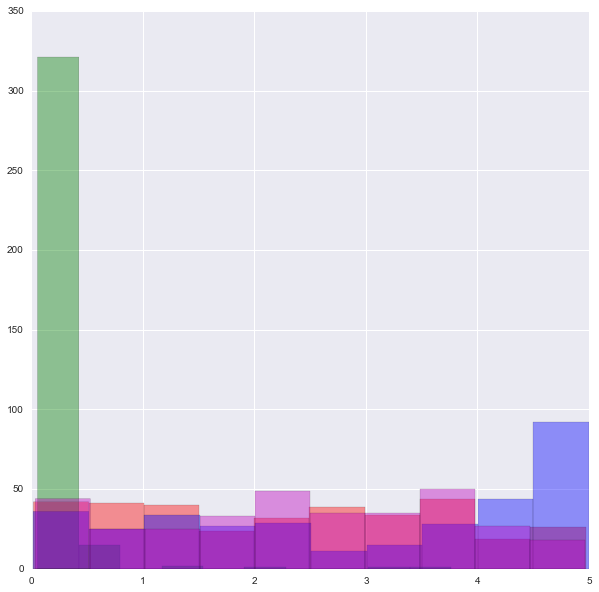

In [69]:
pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    beta_prior_trace = mcmc.trace("beta_prior_%d" % k)[:]
    sns.distplot(beta_prior_trace, label="class %d" % k, color=colors[k], kde=False, bins=10)
    print beta_prior_trace.mean()

# pl.ylim(0, 50)
pl.show()

Plotting sigma_prior_3


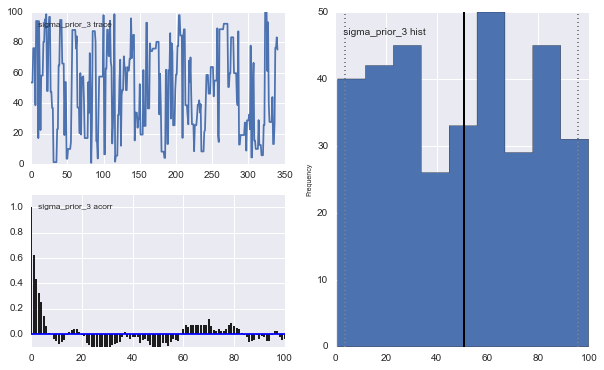

In [70]:
from pymc.Matplot import plot as mcplot

mcplot(mcmc.trace("sigma_prior_3"))

## PyMC3

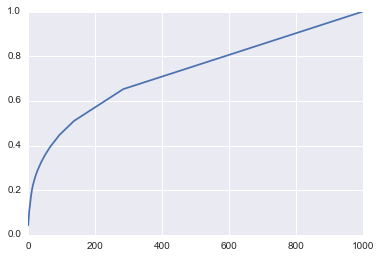

klass  int_0  int_1  int_2  int_3   1  2  3  4  5 ...   91  92  93  94  \
366      0      1      0      1      1  64  8  2  0  0 ...    0   0   0   0   
745      2      1      1      1      0   0  1  2  0  1 ...    0   0   0   0   
391      2      1      0      0      0   3  5  0  0  0 ...    0   0   0   0   
377      2      1      1      0      0   3  1  1  0  0 ...    0   0   0   0   
475      0      0      0      0      0  19  3  1  0  0 ...    0   0   0   0   

     95  96  97  98  99  100  
366   0   0   0   0   0    0  
745   0   0   0   0   0    0  
391   0   0   0   0   0    0  
377   0   0   0   0   0    0  
475   0   0   0   0   0    0  

[5 rows x 105 columns]

In [3]:
import pymc3 as pm3
import theano.tensor as tt

n_users = 100

n_classes = 3
n_interests = 4

p_c=[0.3, 0.2, 0.5]

p_m=[[0.8, 0.2], [0.5, 0.5], [0.1, 0.9]]
mu=[35.0, 20.0, 50.0]
std=10.0
lbd=[2.0, 3.0, 1.0]

p_i=[[0.2, 0.1, 0.7, 0.5], [0.6, 0.1, 0.3, 0.9], [0.9, 0.8, 0.5, 0.1]]

df = pd.DataFrame([generate_user(n_classes, 2, n_interests, p_c, p_m, mu, std, lbd, p_i) for i in xrange(n_users * 10)], columns=["klass"] + ["int_%d" % i for i in xrange(n_interests)] + range(1, 101))
df.fillna(0, inplace=True)

spent = pd.Series(df[range(1, 101)].sum(axis=1), index=df.index)

pl.plot(arange(df.shape[0]), np.cumsum(spent.sort_values(ascending=False)) / spent.sum())
pl.show()

# Take users that generate 80% of income and then sample from them
df = df.ix[spent.sort_values(ascending=False).index[:n_users]]

df.head()

In [4]:
df.groupby(["klass", "int_0"]).size()

klass  int_0
0      0        20
       1         4
1      0         7
       1        10
2      0         7
       1        52
dtype: int64

In [5]:
m3 = pm3.Model()

klass_values = df["klass"].values
interests_values = df[["int_%d" % i for i in xrange(n_interests)]].values

with m3:
    klass_prior = pm3.Dirichlet('klass_prior', a=np.ones(n_classes), shape=n_classes)
    # ensure all clusters have some points
    klass_prior_min_potential = pm3.Potential('klass_prior_min_potential', tt.switch(tt.min(klass_prior) < .1, -np.inf, 0))
    klass_prior_order_potential = pm3.Potential('klass_prior_order_potential', tt.switch(klass_prior[0] > klass_prior[1], -np.inf, 0) + tt.switch(klass_prior[1] > klass_prior[2], -np.inf, 0))
    
    # Interest priors
    interest_priors = pm3.Uniform("interest_priors", lower=0, upper=1, shape=(n_interests, n_classes))
    
    # Class for each user
#     klasses = np.empty(n_users, dtype=object)
    klasses = pm3.Categorical('klasses', p=klass_prior, shape=n_users)
    interests = np.empty((n_users, n_interests), dtype=object)
    for u in xrange(n_users):
#         klasses[u] = pm3.Categorical('klass_%d' % u, p=klass_prior) # , observed=klass_values[u])    
        # Several interests for each user
        for j in xrange(n_interests):
            interests[u, j] = pm3.Bernoulli('interest_%d_%d' % (u, j), p=interest_priors[j, klasses[u]], observed=interests_values[u, j])
    
    step1 = pm3.Metropolis(vars=[klass_prior])
    step2 = pm3.ElemwiseCategoricalStep(var=klasses, values=[0, 1, 2])
    trace = pm3.sample(10000, step=[step1, step2])

Assigned NUTS to interest_priors_interval

00001	#include <Python.h>
00002	#include <iostream>
00003	#include "theano_mod_helper.h"
00004	#include <math.h>
00005	#include <numpy/arrayobject.h>
00006	#include <numpy/arrayscalars.h>
00007	#include <vector>
00008	#include <algorithm>
00009	//////////////////////
00010	////  Support Code
00011	//////////////////////
00012	
00013	
00014	    namespace {
00015	    struct __struct_compiled_op_9981c7b957d292247c61f745ed9dd1b2 {
00016	        PyObject* __ERROR;
00017	
00018	        PyObject* storage_V3;
00019	PyObject* storage_V5;
00020	PyObject* storage_V7;
00021	PyObject* storage_V9;
00022	PyObject* storage_V11;
00023	PyObject* storage_V13;
00024	PyObject* storage_V15;
00025	PyObject* storage_V17;
00026	PyObject* storage_V19;
00027	PyObject* storage_V21;
00028	PyObject* storage_V23;
00029	PyObject* storage_V25;
00030	PyObject* storage_V27;
00031	PyObject* storage_V29;
00032	PyObject* storage_V31;
00033	PyObject* storage_V33;
00034	PyObject* storage_V35;
00035	PyObject* storage_V37;
000


114013	double __DUMMY_496;
114014	
114015	}
114016	__label_494:
114017	
114018	        if (V493) {
114019	            Py_XDECREF(V493);
114020	        }
114021	        
114022	    {Py_XDECREF(py_V493);}
114023	    
114024	double __DUMMY_494;
114025	
114026	}
114027	__label_492:
114028	
114029	        if (V491) {
114030	            Py_XDECREF(V491);
114031	        }
114032	        
114033	    {Py_XDECREF(py_V491);}
114034	    
114035	double __DUMMY_492;
114036	
114037	}
114038	__label_490:
114039	
114040	        if (V489) {
114041	            Py_XDECREF(V489);
114042	        }
114043	        
114044	    {Py_XDECREF(py_V489);}
114045	    
114046	double __DUMMY_490;
114047	
114048	}
114049	__label_488:
114050	
114051	        if (V487) {
114052	            Py_XDECREF(V487);
114053	        }
114054	        
114055	    {Py_XDECREF(py_V487);}
114056	    
114057	double __DUMMY_488;
114058	
114059	}
114060	__label_486:
114061	
114062	        if (V485) {
114063	            Py_XDECREF(V485);
114


/Users/anokhin/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.9-64/tmpkY5WG5/mod.cpp:99933:32: fatal error: bracket nesting level exceeded maximum of 1024
        if (!PyErr_Occurred()) {
                               ^
/Users/anokhin/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.9-64/tmpkY5WG5/mod.cpp:99933:32: note: use -fbracket-depth=N to increase maximum nesting level
1 error generated.




/usr/bin/clang++ -dynamiclib -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -fbracket-depth=1024 -march=core-avx-i -D NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -undefined dynamic_lookup -I/usr/local/lib/python2.7/site-packages/numpy/core/include -I/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/include/python2.7 -I/usr/local/lib/python2.7/site-packages/theano/gof -fvisibility=hidden -o /Users/anokhin/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.9-64/tmpkY5WG5/9981c7b957d292247c61f745ed9dd1b2.so /Users/anokhin/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.9-64/tmpkY5WG5/mod.cpp -L/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib


Exception: ('The following error happened while compiling the node', Elemwise{Composite{(((i0 * i1) + i2 + Switch(i3, log(i4), i5) + Switch(i6, log(i7), i5) + Switch(i8, log(i9), i5) + Switch(i10, log(i11), i5) + Switch(i12, log(i13), i5) + Switch(i14, log(i15), i5) + Switch(i16, log(i17), i5) + Switch(i18, log(i19), i5) + Switch(i20, log(i21), i5) + Switch(i22, log(i23), i5) + Switch(i24, log(i25), i5) + Switch(i26, log(i27), i5) + Switch(i28, log(i29), i5) + Switch(i30, log(i31), i5) + Switch(i32, log(i33), i5) + Switch(i34, log(i35), i5) + Switch(i36, log(i37), i5) + Switch(i38, log(i39), i5) + Switch(i40, log(i41), i5) + Switch(i42, log(i43), i5) + Switch(i44, log(i45), i5) + Switch(i46, log(i47), i5) + Switch(i48, log(i49), i5) + Switch(i50, log(i51), i5) + Switch(i52, log(i53), i5) + Switch(i54, log(i55), i5) + Switch(i56, log(i57), i5) + Switch(i58, log(i59), i5) + Switch(i60, log(i61), i5) + Switch(i62, log(i63), i5) + Switch(i64, log(i65), i5) + Switch(i66, log(i67), i5) + Switch(i68, log(i69), i5) + Switch(i70, log(i71), i5) + Switch(i72, log(i73), i5) + Switch(i74, log(i75), i5) + Switch(i76, log(i77), i5) + Switch(i78, log(i79), i5) + Switch(i80, log(i81), i5) + Switch(i82, log(i83), i5) + Switch(i84, log(i85), i5) + Switch(i86, log(i87), i5) + Switch(i88, log(i89), i5) + Switch(i90, log(i91), i5) + Switch(i92, log(i93), i5) + Switch(i94, log(i95), i5) + Switch(i96, log(i97), i5) + Switch(i98, log(i99), i5) + Switch(i100, log(i101), i5) + Switch(i102, log(i103), i5) + Switch(i104, log(i105), i5) + Switch(i106, log(i107), i5) + Switch(i108, log(i109), i5) + Switch(i110, log(i111), i5) + Switch(i112, log(i113), i5) + Switch(i114, log(i115), i5) + Switch(i116, log(i117), i5) + Switch(i118, log(i119), i5) + Switch(i120, log(i121), i5) + Switch(i122, log(i123), i5) + Switch(i124, log(i125), i5) + Switch(i126, log(i127), i5) + Switch(i128, log(i129), i5) + Switch(i130, log(i131), i5) + Switch(i132, log(i133), i5) + Switch(i134, log(i135), i5) + Switch(i136, log(i137), i5) + Switch(i138, log(i139), i5) + Switch(i140, log(i141), i5) + Switch(i142, log(i143), i5) + Switch(i144, log(i145), i5) + Switch(i146, log(i147), i5) + Switch(i148, log(i149), i5) + Switch(i150, log(i151), i5) + Switch(i152, log(i153), i5) + Switch(i154, log(i155), i5) + Switch(i156, log(i157), i5) + Switch(i158, log(i159), i5) + Switch(i160, log(i161), i5) + Switch(i162, log(i163), i5) + Switch(i164, log(i165), i5) + Switch(i166, log(i167), i5) + Switch(i168, log(i169), i5) + Switch(i170, log(i171), i5) + Switch(i172, log(i173), i5) + Switch(i174, log(i175), i5) + Switch(i176, log(i177), i5) + Switch(i178, log(i179), i5) + Switch(i180, log(i181), i5) + Switch(i182, log(i183), i5) + Switch(i184, log(i185), i5) + Switch(i186, log(i187), i5) + Switch(i188, log(i189), i5) + Switch(i190, log(i191), i5) + Switch(i192, log(i193), i5) + Switch(i194, log(i195), i5) + Switch(i196, log(i197), i5) + Switch(i198, log(i199), i5) + Switch(i200, log(i201), i5) + Switch(i202, log(i203), i5) + Switch(i204, log(i205), i5) + Switch(i206, log(i207), i5) + Switch(i208, log(i209), i5) + Switch(i210, log(i211), i5) + Switch(i212, log(i213), i5) + Switch(i214, log(i215), i5) + Switch(i216, log(i217), i5) + Switch(i218, log(i219), i5) + Switch(i220, log(i221), i5) + Switch(i222, log(i223), i5) + Switch(i224, log(i225), i5) + Switch(i226, log(i227), i5) + Switch(i228, log(i229), i5) + Switch(i230, log(i231), i5) + Switch(i232, log(i233), i5) + Switch(i234, log(i235), i5) + Switch(i236, log(i237), i5) + Switch(i238, log(i239), i5) + Switch(i240, log(i241), i5) + Switch(i242, log(i243), i5) + Switch(i244, log(i245), i5) + Switch(i246, log(i247), i5) + Switch(i248, log(i249), i5) + Switch(i250, log(i251), i5) + Switch(i252, log(i253), i5) + Switch(i254, log(i255), i5) + Switch(i256, log(i257), i5) + Switch(i258, log(i259), i5) + Switch(i260, log(i261), i5) + Switch(i262, log(i263), i5) + Switch(i264, log(i265), i5) + Switch(i266, log(i267), i5) + Switch(i268, log(i269), i5) + Switch(i270, log(i271), i5) + Switch(i272, log(i273), i5) + Switch(i274, log(i275), i5) + Switch(i276, log(i277), i5) + Switch(i278, log(i279), i5) + Switch(i280, log(i281), i5) + Switch(i282, log(i283), i5) + Switch(i284, log(i285), i5) + Switch(i286, log(i287), i5) + Switch(i288, log(i289), i5) + Switch(i290, log(i291), i5) + Switch(i292, log(i293), i5) + Switch(i294, log(i295), i5) + Switch(i296, log(i297), i5) + Switch(i298, log(i299), i5) + Switch(i300, log(i301), i5) + Switch(i302, log(i303), i5) + Switch(i304, log(i305), i5) + Switch(i306, log(i307), i5) + Switch(i308, log(i309), i5) + Switch(i310, log(i311), i5) + Switch(i312, log(i313), i5) + Switch(i314, log(i315), i5) + Switch(i316, log(i317), i5) + Switch(i318, log(i319), i5) + Switch(i320, log(i321), i5) + Switch(i322, log(i323), i5) + Switch(i324, log(i325), i5) + Switch(i326, log(i327), i5) + Switch(i328, log(i329), i5) + Switch(i330, log(i331), i5) + Switch(i332, log(i333), i5) + Switch(i334, log(i335), i5) + Switch(i336, log(i337), i5) + Switch(i338, log(i339), i5) + Switch(i340, log(i341), i5) + Switch(i342, log(i343), i5) + Switch(i344, log(i345), i5) + Switch(i346, log(i347), i5) + Switch(i348, log(i349), i5) + Switch(i350, log(i351), i5) + Switch(i352, log(i353), i5) + Switch(i354, log(i355), i5) + Switch(i356, log(i357), i5) + Switch(i358, log(i359), i5) + Switch(i360, log(i361), i5) + Switch(i362, log(i363), i5) + Switch(i364, log(i365), i5) + Switch(i366, log(i367), i5) + Switch(i368, log(i369), i5) + Switch(i370, log(i371), i5) + Switch(i372, log(i373), i5) + Switch(i374, log(i375), i5) + Switch(i376, log(i377), i5) + Switch(i378, log(i379), i5) + Switch(i380, log(i381), i5) + Switch(i382, log(i383), i5) + Switch(i384, log(i385), i5) + Switch(i386, log(i387), i5) + Switch(i388, log(i389), i5) + Switch(i390, log(i391), i5) + Switch(i392, log(i393), i5) + Switch(i394, log(i395), i5) + Switch(i396, log(i397), i5) + Switch(i398, log(i399), i5) + Switch(i400, log(i401), i5) + Switch(i402, log(i403), i5) + Switch(i404, log(i405), i5) + Switch(i406, log(i407), i5) + Switch(i408, log(i409), i5) + Switch(i410, log(i411), i5) + Switch(i412, log(i413), i5) + Switch(i414, log(i415), i5) + Switch(i416, log(i417), i5) + Switch(i418, log(i419), i5) + Switch(i420, log(i421), i5) + Switch(i422, log(i423), i5) + Switch(i424, log(i425), i5) + Switch(i426, log(i427), i5) + Switch(i428, log(i429), i5) + Switch(i430, log(i431), i5) + Switch(i432, log(i433), i5) + Switch(i434, log(i435), i5) + Switch(i436, log(i437), i5) + Switch(i438, log(i439), i5) + i440 + i441 + i442 + i443 + i444 + i445 + i446 + i447 + i448 + i449 + i450 + i451 + i452 + i453 + i454 + i455 + i456 + i457 + i458 + i459 + i460 + i461 + i462 + i463 + i464 + i465 + i466 + i467 + i468 + i469 + i470 + i471 + i472 + i473 + i474 + i475 + i476 + i477 + i478 + i479 + i480 + i481 + i482 + i483 + i484 + i485 + i486 + i487 + i488 + i489 + i490 + i491 + i492 + i493 + i494 + i495 + i496 + i497 + i498 + i499 + i500 + i501 + i502 + i503 + i504 + i505 + i506 + i507 + i508 + i509 + i510 + i511 + i512 + i513 + i514 + i515 + i516 + i517 + i518 + i519 + i520 + i521 + i522 + i523 + i524 + i525 + i526 + i527 + i528 + i529 + i530 + i531 + i532 + i533 + i534 + i535 + i536 + i537 + i538 + i539 + i540 + i541 + i542 + i543 + i544 + i545 + i546 + i547 + i548 + i549 + i550 + i551 + i552 + i553 + i554 + i555 + i556 + i557 + i558 + i559 + i560 + i561 + i562 + i563 + i564 + i565 + i566 + i567 + i568 + i569 + i570 + i571 + i572 + i573 + i574 + i575 + i576 + i577 + i578 + i579 + i580 + i581 + i582 + i583 + i584 + i585 + i586 + i587 + i588 + i589 + i590 + i591 + i592 + i593 + i594 + i595 + i596 + i597 + i598 + i599 + i600 + i601 + i602 + i603 + i604 + i605 + i606 + i607 + i608 + i609 + i610 + i611 + i612 + i613 + i614 + i615 + i616 + i617 + i618 + i619 + i620 + i621) - (i622 + i623 + i624 + i625 + i626 + i627 + i628 + i629 + i630 + i631 + i632 + i633 + i634 + i635 + i636 + i637 + i638 + i639 + i640 + i641 + i642 + i643 + i644 + i645 + i646 + i647 + i648 + i649 + i650 + i651 + i652 + i653 + i654 + i655 + i656 + i657 + i658 + i659 + i660 + i661 + i662 + i663 + i664 + i665 + i666 + i667 + i668 + i669 + i670 + i671 + i672 + i673 + i674 + i675 + i676 + i677 + i678 + i679 + i680 + i681 + i682 + i683 + i684 + i685 + i686 + i687 + i688 + i689 + i690 + i691 + i692 + i693 + i694 + i695 + i696 + i697 + i698 + i699 + i700 + i701 + i702 + i703 + i704 + i705 + i706 + i707 + i708 + i709 + i710 + i711 + i712 + i713 + i714 + i715 + i716 + i717 + i718 + i719 + i720 + i721 + i722 + i723 + i724 + i725 + i726 + i727 + i728 + i729 + i730 + i731 + i732 + i733 + i734 + i735 + i736 + i737 + i738 + i739 + i740 + i741 + i742 + i743 + i744 + i745 + i746 + i747 + i748 + i749 + i750 + i751 + i752 + i753 + i754 + i755 + i756 + i757 + i758 + i759 + i760 + i761 + i762 + i763 + i764 + i765 + i766 + i767 + i768 + i769 + i770 + i771 + i772 + i773 + i774 + i775 + i776 + i777 + i778 + i779 + i780 + i781 + i782 + i783 + i784 + i785 + i786 + i787 + i788 + i789 + i790 + i791 + i792 + i793 + i794 + i795 + i796 + i797 + i798 + i799 + i800 + i801 + i802 + i803 + i804 + i805 + i806 + i807 + i808 + i809 + i810 + i811 + i812 + i813 + i814 + i815 + i816 + i817 + i818 + i819 + i820 + i821 + i822 + i823 + i824 + i825 + i826 + i827 + i828 + i829 + i830 + i831 + i832 + i833 + i834 + i835 + i836 + i837 + i838 + i839 + i840 + i841 + i842 + i843 + i844 + i845 + i846 + i847 + i848 + i849 + i850 + i851 + i852 + i853 + i854 + i855 + i856 + i857 + i858 + i859 + i860 + i861 + i862 + i863 + i864 + i865 + i866 + i867 + i868 + i869 + i870 + i871 + i872 + i873 + i874 + i875 + i876 + i877 + i878 + i879 + i880 + i881 + i882 + i883 + i884 + i885 + i886 + i887 + i888 + i889 + i890 + i891 + i892 + i893 + i894 + i895 + i896 + i897 + i898 + i899 + i900 + i901 + i902 + i903 + i904 + i905 + i906 + i907 + i908 + i909 + i910 + i911 + i912 + i913 + i914 + i915 + i916 + i917 + i918 + i919 + i920 + i921 + i922 + i923 + i924 + i925 + i926 + i927 + i928 + i929 + i930 + i931 + i932 + i933 + i934 + i935 + i936 + i937 + i938 + i939 + i940 + i941 + i942 + i943 + i944 + i945 + i946 + i947 + i948 + i949 + i950 + i951 + i952 + i953 + i954 + i955 + i956 + i957 + i958 + i959 + i960 + i961 + i962 + i963 + i964 + i965 + i966 + i967 + i968 + i969 + i970 + i971 + i972 + i973 + i974 + i975 + i976 + i977 + i978 + i979 + i980 + i981 + i982 + i983 + i984 + i985 + i986 + i987 + i988 + i989 + i990 + i991 + i992 + i993 + i994 + i995 + i996 + i997 + i998 + i999 + i1000 + i1001 + i1002 + i1003 + i1004 + i1005 + i1006 + i1007 + i1008 + i1009 + i1010 + i1011 + i1012 + i1013 + i1014 + i1015 + i1016 + i1017 + i1018 + i1019 + i1020 + i1021 + i1022 + (i0 * i1023)))}}(TensorConstant{0.5}, InplaceDimShuffle{}.0, Sum{acc_dtype=float64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, TensorConstant{-inf}, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Elemwise{sub,no_inplace}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{(GE(i0, i1) * LE(i0, i2))}}.0, Subtensor{int64, int64}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Sum{acc_dtype=float64}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, Elemwise{Composite{Switch(i0, log(i1), i2)}}.0, InplaceDimShuffle{}.0), '\n', 'Compilation failed (return status=1): /Users/anokhin/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.9-64/tmpkY5WG5/mod.cpp:99933:32: fatal error: bracket nesting level exceeded maximum of 1024.         if (!PyErr_Occurred()) {.                                ^. /Users/anokhin/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-2.7.9-64/tmpkY5WG5/mod.cpp:99933:32: note: use -fbracket-depth=N to increase maximum nesting level. 1 error generated.. ', '[Elemwise{Composite{(((i0 * i1) + i2 + Switch(i3, log(i4), i5) + Switch(i6, log(i7), i5) + Switch(i8, log(i9), i5) + Switch(i10, log(i11), i5) + Switch(i12, log(i13), i5) + Switch(i14, log(i15), i5) + Switch(i16, log(i17), i5) + Switch(i18, log(i19), i5) + Switch(i20, log(i21), i5) + Switch(i22, log(i23), i5) + Switch(i24, log(i25), i5) + Switch(i26, log(i27), i5) + Switch(i28, log(i29), i5) + Switch(i30, log(i31), i5) + Switch(i32, log(i33), i5) + Switch(i34, log(i35), i5) + Switch(i36, log(i37), i5) + Switch(i38, log(i39), i5) + Switch(i40, log(i41), i5) + Switch(i42, log(i43), i5) + Switch(i44, log(i45), i5) + Switch(i46, log(i47), i5) + Switch(i48, log(i49), i5) + Switch(i50, log(i51), i5) + Switch(i52, log(i53), i5) + Switch(i54, log(i55), i5) + Switch(i56, log(i57), i5) + Switch(i58, log(i59), i5) + Switch(i60, log(i61), i5) + Switch(i62, log(i63), i5) + Switch(i64, log(i65), i5) + Switch(i66, log(i67), i5) + Switch(i68, log(i69), i5) + Switch(i70, log(i71), i5) + Switch(i72, log(i73), i5) + Switch(i74, log(i75), i5) + Switch(i76, log(i77), i5) + Switch(i78, log(i79), i5) + Switch(i80, log(i81), i5) + Switch(i82, log(i83), i5) + Switch(i84, log(i85), i5) + Switch(i86, log(i87), i5) + Switch(i88, log(i89), i5) + Switch(i90, log(i91), i5) + Switch(i92, log(i93), i5) + Switch(i94, log(i95), i5) + Switch(i96, log(i97), i5) + Switch(i98, log(i99), i5) + Switch(i100, log(i101), i5) + Switch(i102, log(i103), i5) + Switch(i104, log(i105), i5) + Switch(i106, log(i107), i5) + Switch(i108, log(i109), i5) + Switch(i110, log(i111), i5) + Switch(i112, log(i113), i5) + Switch(i114, log(i115), i5) + Switch(i116, log(i117), i5) + Switch(i118, log(i119), i5) + Switch(i120, log(i121), i5) + Switch(i122, log(i123), i5) + Switch(i124, log(i125), i5) + Switch(i126, log(i127), i5) + Switch(i128, log(i129), i5) + Switch(i130, log(i131), i5) + Switch(i132, log(i133), i5) + Switch(i134, log(i135), i5) + Switch(i136, log(i137), i5) + Switch(i138, log(i139), i5) + Switch(i140, log(i141), i5) + Switch(i142, log(i143), i5) + Switch(i144, log(i145), i5) + Switch(i146, log(i147), i5) + Switch(i148, log(i149), i5) + Switch(i150, log(i151), i5) + Switch(i152, log(i153), i5) + Switch(i154, log(i155), i5) + Switch(i156, log(i157), i5) + Switch(i158, log(i159), i5) + Switch(i160, log(i161), i5) + Switch(i162, log(i163), i5) + Switch(i164, log(i165), i5) + Switch(i166, log(i167), i5) + Switch(i168, log(i169), i5) + Switch(i170, log(i171), i5) + Switch(i172, log(i173), i5) + Switch(i174, log(i175), i5) + Switch(i176, log(i177), i5) + Switch(i178, log(i179), i5) + Switch(i180, log(i181), i5) + Switch(i182, log(i183), i5) + Switch(i184, log(i185), i5) + Switch(i186, log(i187), i5) + Switch(i188, log(i189), i5) + Switch(i190, log(i191), i5) + Switch(i192, log(i193), i5) + Switch(i194, log(i195), i5) + Switch(i196, log(i197), i5) + Switch(i198, log(i199), i5) + Switch(i200, log(i201), i5) + Switch(i202, log(i203), i5) + Switch(i204, log(i205), i5) + Switch(i206, log(i207), i5) + Switch(i208, log(i209), i5) + Switch(i210, log(i211), i5) + Switch(i212, log(i213), i5) + Switch(i214, log(i215), i5) + Switch(i216, log(i217), i5) + Switch(i218, log(i219), i5) + Switch(i220, log(i221), i5) + Switch(i222, log(i223), i5) + Switch(i224, log(i225), i5) + Switch(i226, log(i227), i5) + Switch(i228, log(i229), i5) + Switch(i230, log(i231), i5) + Switch(i232, log(i233), i5) + Switch(i234, log(i235), i5) + Switch(i236, log(i237), i5) + Switch(i238, log(i239), i5) + Switch(i240, log(i241), i5) + Switch(i242, log(i243), i5) + Switch(i244, log(i245), i5) + Switch(i246, log(i247), i5) + Switch(i248, log(i249), i5) + Switch(i250, log(i251), i5) + Switch(i252, log(i253), i5) + Switch(i254, log(i255), i5) + Switch(i256, log(i257), i5) + Switch(i258, log(i259), i5) + Switch(i260, log(i261), i5) + Switch(i262, log(i263), i5) + Switch(i264, log(i265), i5) + Switch(i266, log(i267), i5) + Switch(i268, log(i269), i5) + Switch(i270, log(i271), i5) + Switch(i272, log(i273), i5) + Switch(i274, log(i275), i5) + Switch(i276, log(i277), i5) + Switch(i278, log(i279), i5) + Switch(i280, log(i281), i5) + Switch(i282, log(i283), i5) + Switch(i284, log(i285), i5) + Switch(i286, log(i287), i5) + Switch(i288, log(i289), i5) + Switch(i290, log(i291), i5) + Switch(i292, log(i293), i5) + Switch(i294, log(i295), i5) + Switch(i296, log(i297), i5) + Switch(i298, log(i299), i5) + Switch(i300, log(i301), i5) + Switch(i302, log(i303), i5) + Switch(i304, log(i305), i5) + Switch(i306, log(i307), i5) + Switch(i308, log(i309), i5) + Switch(i310, log(i311), i5) + Switch(i312, log(i313), i5) + Switch(i314, log(i315), i5) + Switch(i316, log(i317), i5) + Switch(i318, log(i319), i5) + Switch(i320, log(i321), i5) + Switch(i322, log(i323), i5) + Switch(i324, log(i325), i5) + Switch(i326, log(i327), i5) + Switch(i328, log(i329), i5) + Switch(i330, log(i331), i5) + Switch(i332, log(i333), i5) + Switch(i334, log(i335), i5) + Switch(i336, log(i337), i5) + Switch(i338, log(i339), i5) + Switch(i340, log(i341), i5) + Switch(i342, log(i343), i5) + Switch(i344, log(i345), i5) + Switch(i346, log(i347), i5) + Switch(i348, log(i349), i5) + Switch(i350, log(i351), i5) + Switch(i352, log(i353), i5) + Switch(i354, log(i355), i5) + Switch(i356, log(i357), i5) + Switch(i358, log(i359), i5) + Switch(i360, log(i361), i5) + Switch(i362, log(i363), i5) + Switch(i364, log(i365), i5) + Switch(i366, log(i367), i5) + Switch(i368, log(i369), i5) + Switch(i370, log(i371), i5) + Switch(i372, log(i373), i5) + Switch(i374, log(i375), i5) + Switch(i376, log(i377), i5) + Switch(i378, log(i379), i5) + Switch(i380, log(i381), i5) + Switch(i382, log(i383), i5) + Switch(i384, log(i385), i5) + Switch(i386, log(i387), i5) + Switch(i388, log(i389), i5) + Switch(i390, log(i391), i5) + Switch(i392, log(i393), i5) + Switch(i394, log(i395), i5) + Switch(i396, log(i397), i5) + Switch(i398, log(i399), i5) + Switch(i400, log(i401), i5) + Switch(i402, log(i403), i5) + Switch(i404, log(i405), i5) + Switch(i406, log(i407), i5) + Switch(i408, log(i409), i5) + Switch(i410, log(i411), i5) + Switch(i412, log(i413), i5) + Switch(i414, log(i415), i5) + Switch(i416, log(i417), i5) + Switch(i418, log(i419), i5) + Switch(i420, log(i421), i5) + Switch(i422, log(i423), i5) + Switch(i424, log(i425), i5) + Switch(i426, log(i427), i5) + Switch(i428, log(i429), i5) + Switch(i430, log(i431), i5) + Switch(i432, log(i433), i5) + Switch(i434, log(i435), i5) + Switch(i436, log(i437), i5) + Switch(i438, log(i439), i5) + i440 + i441 + i442 + i443 + i444 + i445 + i446 + i447 + i448 + i449 + i450 + i451 + i452 + i453 + i454 + i455 + i456 + i457 + i458 + i459 + i460 + i461 + i462 + i463 + i464 + i465 + i466 + i467 + i468 + i469 + i470 + i471 + i472 + i473 + i474 + i475 + i476 + i477 + i478 + i479 + i480 + i481 + i482 + i483 + i484 + i485 + i486 + i487 + i488 + i489 + i490 + i491 + i492 + i493 + i494 + i495 + i496 + i497 + i498 + i499 + i500 + i501 + i502 + i503 + i504 + i505 + i506 + i507 + i508 + i509 + i510 + i511 + i512 + i513 + i514 + i515 + i516 + i517 + i518 + i519 + i520 + i521 + i522 + i523 + i524 + i525 + i526 + i527 + i528 + i529 + i530 + i531 + i532 + i533 + i534 + i535 + i536 + i537 + i538 + i539 + i540 + i541 + i542 + i543 + i544 + i545 + i546 + i547 + i548 + i549 + i550 + i551 + i552 + i553 + i554 + i555 + i556 + i557 + i558 + i559 + i560 + i561 + i562 + i563 + i564 + i565 + i566 + i567 + i568 + i569 + i570 + i571 + i572 + i573 + i574 + i575 + i576 + i577 + i578 + i579 + i580 + i581 + i582 + i583 + i584 + i585 + i586 + i587 + i588 + i589 + i590 + i591 + i592 + i593 + i594 + i595 + i596 + i597 + i598 + i599 + i600 + i601 + i602 + i603 + i604 + i605 + i606 + i607 + i608 + i609 + i610 + i611 + i612 + i613 + i614 + i615 + i616 + i617 + i618 + i619 + i620 + i621) - (i622 + i623 + i624 + i625 + i626 + i627 + i628 + i629 + i630 + i631 + i632 + i633 + i634 + i635 + i636 + i637 + i638 + i639 + i640 + i641 + i642 + i643 + i644 + i645 + i646 + i647 + i648 + i649 + i650 + i651 + i652 + i653 + i654 + i655 + i656 + i657 + i658 + i659 + i660 + i661 + i662 + i663 + i664 + i665 + i666 + i667 + i668 + i669 + i670 + i671 + i672 + i673 + i674 + i675 + i676 + i677 + i678 + i679 + i680 + i681 + i682 + i683 + i684 + i685 + i686 + i687 + i688 + i689 + i690 + i691 + i692 + i693 + i694 + i695 + i696 + i697 + i698 + i699 + i700 + i701 + i702 + i703 + i704 + i705 + i706 + i707 + i708 + i709 + i710 + i711 + i712 + i713 + i714 + i715 + i716 + i717 + i718 + i719 + i720 + i721 + i722 + i723 + i724 + i725 + i726 + i727 + i728 + i729 + i730 + i731 + i732 + i733 + i734 + i735 + i736 + i737 + i738 + i739 + i740 + i741 + i742 + i743 + i744 + i745 + i746 + i747 + i748 + i749 + i750 + i751 + i752 + i753 + i754 + i755 + i756 + i757 + i758 + i759 + i760 + i761 + i762 + i763 + i764 + i765 + i766 + i767 + i768 + i769 + i770 + i771 + i772 + i773 + i774 + i775 + i776 + i777 + i778 + i779 + i780 + i781 + i782 + i783 + i784 + i785 + i786 + i787 + i788 + i789 + i790 + i791 + i792 + i793 + i794 + i795 + i796 + i797 + i798 + i799 + i800 + i801 + i802 + i803 + i804 + i805 + i806 + i807 + i808 + i809 + i810 + i811 + i812 + i813 + i814 + i815 + i816 + i817 + i818 + i819 + i820 + i821 + i822 + i823 + i824 + i825 + i826 + i827 + i828 + i829 + i830 + i831 + i832 + i833 + i834 + i835 + i836 + i837 + i838 + i839 + i840 + i841 + i842 + i843 + i844 + i845 + i846 + i847 + i848 + i849 + i850 + i851 + i852 + i853 + i854 + i855 + i856 + i857 + i858 + i859 + i860 + i861 + i862 + i863 + i864 + i865 + i866 + i867 + i868 + i869 + i870 + i871 + i872 + i873 + i874 + i875 + i876 + i877 + i878 + i879 + i880 + i881 + i882 + i883 + i884 + i885 + i886 + i887 + i888 + i889 + i890 + i891 + i892 + i893 + i894 + i895 + i896 + i897 + i898 + i899 + i900 + i901 + i902 + i903 + i904 + i905 + i906 + i907 + i908 + i909 + i910 + i911 + i912 + i913 + i914 + i915 + i916 + i917 + i918 + i919 + i920 + i921 + i922 + i923 + i924 + i925 + i926 + i927 + i928 + i929 + i930 + i931 + i932 + i933 + i934 + i935 + i936 + i937 + i938 + i939 + i940 + i941 + i942 + i943 + i944 + i945 + i946 + i947 + i948 + i949 + i950 + i951 + i952 + i953 + i954 + i955 + i956 + i957 + i958 + i959 + i960 + i961 + i962 + i963 + i964 + i965 + i966 + i967 + i968 + i969 + i970 + i971 + i972 + i973 + i974 + i975 + i976 + i977 + i978 + i979 + i980 + i981 + i982 + i983 + i984 + i985 + i986 + i987 + i988 + i989 + i990 + i991 + i992 + i993 + i994 + i995 + i996 + i997 + i998 + i999 + i1000 + i1001 + i1002 + i1003 + i1004 + i1005 + i1006 + i1007 + i1008 + i1009 + i1010 + i1011 + i1012 + i1013 + i1014 + i1015 + i1016 + i1017 + i1018 + i1019 + i1020 + i1021 + i1022 + (i0 * i1023)))}}(TensorConstant{0.5}, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, TensorConstant{-inf}, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(int8, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>)]')

In [19]:
with m3:
    step1 = pm3.Metropolis(vars=[klass_prior])
    step2 = pm3.ElemwiseCategoricalStep(var=klasses, values=[0, 1, 2])
    trace = pm3.sample(100000, step=[step1, step2])

Assigned NUTS to interest_priors_interval
 [-----------------100%-----------------] 100000 of 100000 complete in 886.9 sec

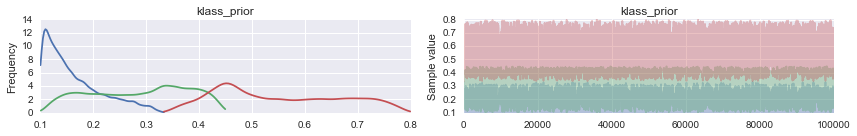

In [20]:
with m3:
    pm3.plots.traceplot(trace, ['klass_prior'])

## Viz

In [9]:
from pymc.Matplot import plot as mcplot

n_users = 300
n_classes = 4

interests = ["male", "young", "old", "rich", "edu", "family", "married"]

In [10]:
mcmc = pm.database.pickle.load('/Users/anokhin/Desktop/ok_300_4_1.pickle')

Cluster 0, mean 0.01
Cluster 1, mean 0.95
Cluster 2, mean 0.01
Cluster 3, mean 0.03


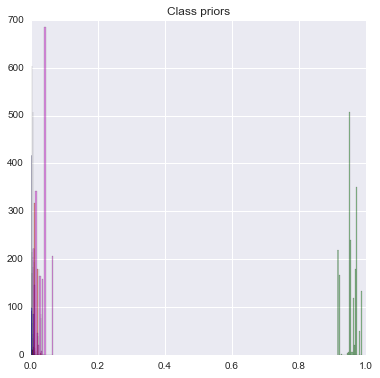

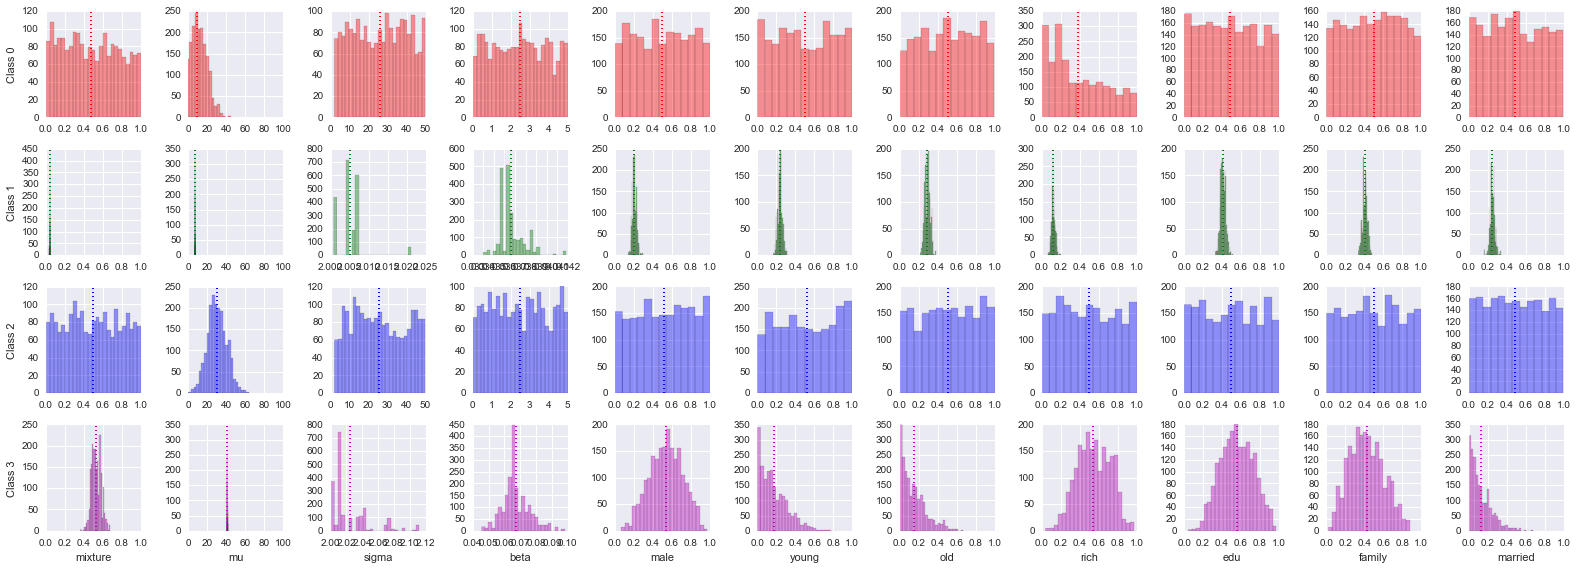

In [11]:
colors = ['r', 'g', 'b', 'm', 'y', 'c']

pl.figure(figsize=(6, 6))

klass_trace = mcmc.trace("klass_prior").gettrace(burn=1000, thin=2)[:].reshape(-1, n_classes)

for klass in xrange(n_classes):
    sns.distplot(klass_trace[:, klass], kde=False, color=colors[klass])    
    print "Cluster %d, mean %.2f" % (klass, klass_trace[:, klass].mean())    
pl.title("Class priors")
pl.xlim(0, 1)
pl.show()

n_features = n_interests + 1 + 1 + 1 + 1
pl.figure(figsize=(n_features * 2, n_classes * 2))
for klass in xrange(n_classes):   
    
    # mixture
    pl.subplot(n_classes, n_features, klass * n_features + 1)
    mix_prior_trace = mcmc.trace("mixture_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(mix_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(mix_prior_trace.mean(), ls=':', lw=2, color=colors[klass])
    pl.xlim(0, 1)    
    
    pl.ylabel("Class %d" % klass)    
    if klass == (n_classes - 1):
        pl.xlabel("mixture")
    
    # mu
    pl.subplot(n_classes, n_features, klass * n_features + 2)
    mu_prior_trace = mcmc.trace("mu_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(mu_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(mu_prior_trace.mean(), ls=':', lw=2, color=colors[klass])
    pl.xlim(0, 100)
    
    if klass == (n_classes - 1):
        pl.xlabel("mu")
    
    # sigma
    pl.subplot(n_classes, n_features, klass * n_features + 3)
    sigma_prior_trace = mcmc.trace("sigma_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(sigma_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(sigma_prior_trace.mean(), ls=':', lw=2, color=colors[klass])    
    
    if klass == (n_classes - 1):
        pl.xlabel("sigma")
    
    # beta
    pl.subplot(n_classes, n_features, klass * n_features + 4)
    beta_prior_trace = mcmc.trace("beta_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(beta_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(beta_prior_trace.mean(), ls=':', lw=2, color=colors[klass])

    if klass == (n_classes - 1):
        pl.xlabel("beta")
    
    for inter in xrange(n_interests):        
        int_prior_trace = mcmc.trace("interest_prior_%d_%d" % (inter, klass)).gettrace(burn=1000, thin=2)[:]
        pl.subplot(n_classes, n_features, klass * n_features + inter + 5)
        pl.axvline(int_prior_trace.mean(), ls=':', lw=2, color=colors[klass])
        sns.distplot(int_prior_trace, kde=False, color=colors[klass])
        pl.xlim(0, 1)
        if klass == (n_classes - 1):
            pl.xlabel(interests[inter])
    
pl.tight_layout()
pl.show()

Class=0 [ mixture=0.475, mu=9.626, sigma=26.029, beta=2.475]
Class=1 [ mixture=0.039, mu=7.165, sigma=2.005, beta=0.037]
Class=2 [ mixture=0.496, mu=30.287, sigma=25.745, beta=2.495]
Class=3 [ mixture=0.528, mu=41.039, sigma=2.024, beta=0.067]


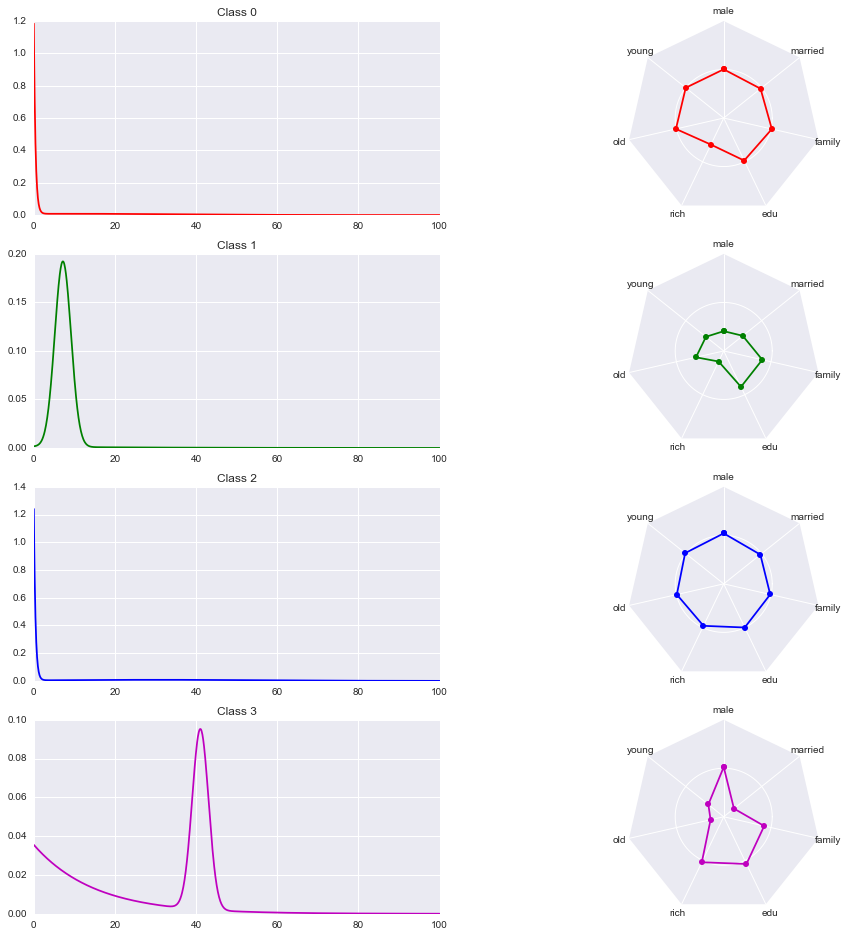

In [13]:
from radar import _radar_factory
import matplotlib.pyplot as pl

theta = _radar_factory(n_interests)

fig = pl.figure(figsize=(16, n_classes * 4))
for klass in xrange(n_classes):
    p_mix = mcmc.trace("mixture_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    mu = mcmc.trace("mu_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    sigma = mcmc.trace("sigma_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    beta = mcmc.trace("beta_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    
    print "Class=%d [ mixture=%.3f, mu=%.3f, sigma=%.3f, beta=%.3f]" % (klass, p_mix, mu, sigma, beta) 
    
    pl.subplot(n_classes, 2, klass * 2 + 1)
    x = np.linspace(0, 100, 1000)
    y = p_mix * ss.expon.pdf(x, 0, 1/beta) + (1 - p_mix) * ss.norm.pdf(x, mu, sigma)
    pl.plot(x, y, color=colors[klass])
    pl.xlim(0, 100)
    pl.title("Class %d" % klass)    
    
    ax = pl.gcf().add_subplot(n_classes, 2, klass * 2 + 2, projection='radar')
    ints = [mcmc.trace("interest_prior_%d_%d" % (i, klass))[:].mean() for i in xrange(n_interests)]           
    ax.plot(theta, ints, 'o-', color=colors[klass], markersize=6)
    ax.set_varlabels(interests)
    pl.ylim(0, 1)
    pl.yticks([0.5], [])
    
pl.show()